In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import os
import sys
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
from mpl_toolkits.mplot3d import Axes3D
from astropy.cosmology import WMAP9 as cosmo
from astropy.constants import c
%matplotlib inline

//anaconda/envs/astroconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
#Get current path so program can tell if this is being run on Kelly's or Rose's computer
mypath=os.getcwd()
if mypath.find('rfinn') > -1:
    print "Running on Rose's computer"
    #agcfile='/Users/rfinn/idl/programs/idl_alfa/agctotal.sav'
    gitpath='/Users/rfinn/github/'
    nsapath = '/Users/rfinn/research/NSA/'
    gswlpath = '/Users/rfinn/Dropbox/Research/GSWLC/'
    agcpath = '/Users/rfinn/research/AGC/'
elif mypath.find('kelly') > -1:
    print "Running on Kellys's computer"
    gitpath='/Users/kellywhalen/Github/'
    nsapath = '/Users/kellywhalen/RESEARCH/NSA_table/'
    gswlpath = '/Users/kellywhalen/RESEARCH/GSWLC/'
    agcpath = '/Users/kellywhalen/RESEARCH/AGC/'



Running on Rose's computer


In [6]:
#Read in files needed to create plots
galex = fits.getdata(gitpath+'Virgo/tables/GALEX-WISE-allsky_virgo.fits')
#galexD = fits.getdata(gitpath+'Virgo/tables/GALEX-WISE-deepsky_virgo.fits')
#galexMID = fits.getdata(gitpath+'Virgo/tables/GALEX-WISE-mid_virgo.fits')
nsa = fits.getdata(gitpath+'Virgo/tables/VirgoCatalog.fits')
#nsa = fits.getdata('/Users/kellywhalen/Github/Virgo/tables/nsa_v0_1_2.fits')
nsadict=dict((a,b) for a,b in zip(nsa.NSAID,np.arange(len(nsa.NSAID))))
massFile = fits.getdata(gitpath+'Virgo/tables/StellarMasstoNSA_virgo.fits')
targets = fits.getdata(gitpath+'Virgo/tables/CO-HI_virgo.fits')
wise = fits.getdata(gitpath+'Virgo/tables/WISE_virgo.fits')

# Calculating Distances from Virgo Center

In [7]:
#Selecting Galaxies in the vicinity of Virgo
raflag = (nsa.RA > 115.) & (nsa.RA < 240.)
decflag= (nsa.DEC > -30.) & (nsa.DEC < 60.)
velflag =  (nsa.Z*3.e5 < 3000.) # & (nsa.Z*3.e5 > 1000.) 
vflag = raflag & decflag & velflag 

#nsa = nsa[vflag]

# define nsa RA and Dec as SkyCoord
nsa_sc = SkyCoord(nsa.RA*u.degree, nsa.DEC*u.degree)


# convert helio-centric velocity to units of km/s
V_H = nsa.Z*c.to('km/s')

# 1. correction of observed heliocentric velocity to centroid of local group
# VLG = VH - 79 cos l cos b + 296 sin l cos b - 36 sin b

V_LG = - 79.*u.km/u.second*np.cos(nsa_sc.galactic.l.radian)*np.cos(nsa_sc.galactic.b.radian) + 296.*u.km/u.second*np.sin(nsa_sc.galactic.l.radian)*np.cos(nsa_sc.galactic.b.radian) - 36.*u.km/u.second*np.sin(nsa_sc.galactic.b.radian)

# from Mould+2000, ApJ, 529, 786
# not sure if we are using this equation exactly right

V_fid = 200.*u.km/u.second # infall of LG into Virgo?
# Virgo coordinates given by Mould+2000
Virgo = SkyCoord('12h28m19s', '+12d40m00s', frame='fk5',equinox='J1950.') # epoch = 1950
Virgo = Virgo.transform_to(FK5(equinox='J2000'))
### need to fix this to use spherical distance
#theta = np.sqrt((nsa_sc.ra.radian - Virgo.ra.radian)**2 + (nsa_sc.dec.radian - Virgo.dec.radian)**2)
theta = Virgo.separation(nsa_sc).radian 
# cluster radius in deg
gamma = 2.

V_a = 1035.*u.km/u.second # recession vel of Virgo from Mould+2000
#V_a = 1221.*u.km/u.second # recession vel of Virgo as calculated by Gianluca
V_o = nsa.Z*c.to('km/s') + V_LG # recession velocities of the galaxies
r_oa = np.sqrt(V_o**2 + V_a**2 - 2.*V_o*V_a*np.cos(theta))
V_infall = V_fid*(np.cos(theta) + (V_o - V_a*np.cos(theta))/r_oa*(r_oa/V_a)**(1-gamma))

V_fid = 400.*u.km/u.second # infall of LG into Virgo?
# GA coordinates given by Mould+2000
GA = SkyCoord('13h20m00s', '+44d00m00s', frame='fk5',equinox='J1950.') # epoch = 1950
GA = GA.transform_to(FK5(equinox='J2000'))
theta = GA.separation(nsa_sc).radian
#theta = np.sqrt((nsa_sc.ra.radian - GA.ra.radian)**2 + (nsa_sc.dec.radian - GA.dec.radian)**2)

gamma = 2.
V_a = 4380.*u.km/u.second # recession vel of Great Attractor from Mould+2000
V_o = nsa.Z*c.to('km/s') + V_LG # recession velocities of the galaxies
r_oa = np.sqrt(V_o**2 + V_a**2 - 2.*V_o*V_a*np.cos(theta))
V_GA = V_fid*(np.cos(theta) + (V_o - V_a*np.cos(theta))/r_oa*(r_oa/V_a)**(1-gamma))

# Final, correction cosmic velocity is
#
#  Vcosmic = VH + Vc,LG + Vin,Virgo + Vin,GA + Vin,Shap + ...

# ## Tranforming to Supergalactic Coordinates##
# 
# Looking to match the plots shown in Kim+2016
# 
# https://arxiv.org/abs/1611.00437

#Plot of Virgo Cluster in galactic coordinates
V_cosmic = V_H + V_LG + V_infall +V_GA
V = V_cosmic

#SGX = V/cosmo.H(0)*np.cos(nsa_sc.supergalactic.sgl.radian)*np.cos(nsa_sc.supergalactic.sgb.radian)
#SGY = V/cosmo.H(0)*np.sin(nsa_sc.supergalactic.sgl.radian)*np.cos(nsa_sc.supergalactic.sgb.radian)
#SGZ = V/cosmo.H(0)*np.sin(nsa_sc.supergalactic.sgb.radian)


# using H0 = 74 to match Kim+2016 paper
#H0 = 74.*u.km/u.second/u.Mpc
H0 = 100.*u.km/u.second/u.Mpc #Kim's email
SGX = V/H0*np.cos(nsa_sc.supergalactic.sgl.radian)*np.cos(nsa_sc.supergalactic.sgb.radian)
SGY = V/H0*np.sin(nsa_sc.supergalactic.sgl.radian)*np.cos(nsa_sc.supergalactic.sgb.radian)
SGZ = V/H0*np.sin(nsa_sc.supergalactic.sgb.radian)

distance_to_virgo = 16.5*u.Mpc #Mpc
SGX_Virgo = distance_to_virgo*np.cos(Virgo.supergalactic.sgl.radian)*np.cos(Virgo.supergalactic.sgb.radian)
SGY_Virgo = distance_to_virgo*np.sin(Virgo.supergalactic.sgl.radian)*np.cos(Virgo.supergalactic.sgb.radian)
SGZ_Virgo = distance_to_virgo*np.sin(Virgo.supergalactic.sgb.radian)

# difference 
DSGX = SGX - SGX_Virgo
DSGY = SGY - SGY_Virgo
DSGZ = SGZ - SGZ_Virgo

distV = np.sqrt(DSGX**2 + DSGY**2 + DSGZ**2) 

## SFR vs. Stellar Mass Plots (Using GALEX_WISE data)

## Setting up SFRs and Stellar Masses

In [30]:
logSFR_SED = galexAS.logSFR_SED
logSFR_UW = galexAS.logSFR_MIR_UW
logMass = massFile.MSTAR_50

dataflag = (galexAS.objID != 0) & (massFile.ISEDFIT_ID !=0)
UWflag = galex.flag_unwise == 0
SEDflag = galex.flag_SED == 0
targetflag = targets.IsInFilament != 0

### Virgo galaxies

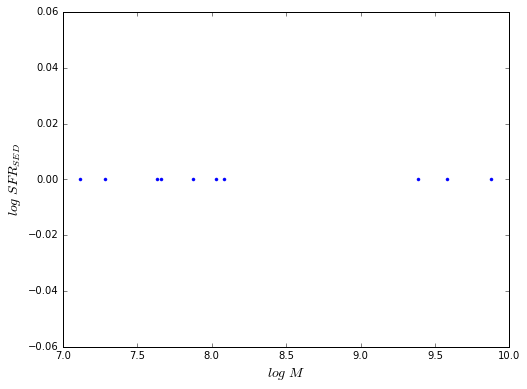

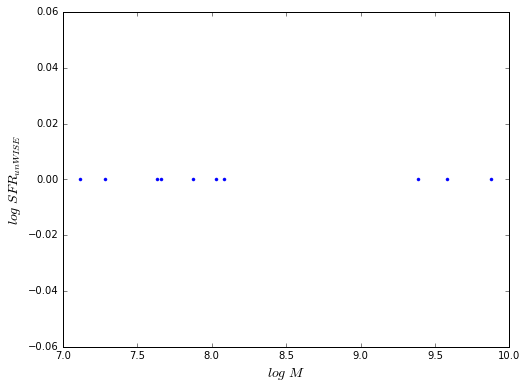

In [31]:
clusterFlag = (distV > 1.*u.Mpc) & (distV < 3.*u.Mpc) & dataflag

plt.figure(figsize = (8,6))
plt.plot(logMass[clusterFlag & SEDflag], logSFR_SED[clusterFlag & SEDflag], '.')
plt.xlabel('$log \ M$', fontsize = 14)
plt.ylabel('$log \ SFR_{SED}$', fontsize = 14)

plt.figure(figsize = (8,6))
plt.plot(logMass[clusterFlag & UWflag], logSFR_UW[clusterFlag & UWflag], '.')
plt.xlabel('$log \ M$', fontsize = 14)
plt.ylabel('$log \ SFR_{unWISE}$', fontsize = 14)

### All galaxies outside of Virgo

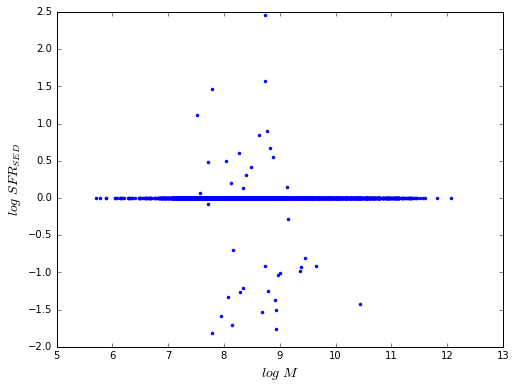

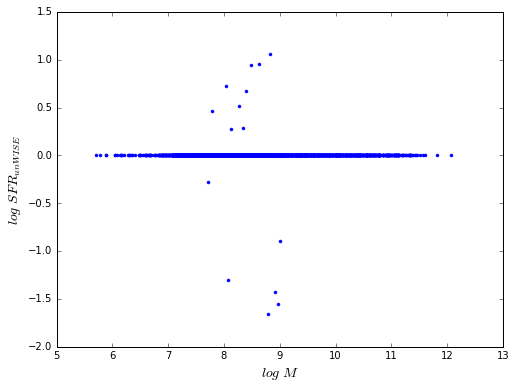

In [32]:
filamentFlag = (distV > 3.*u.Mpc) & (distV < 18.*u.Mpc) & dataflag 

plt.figure(figsize = (8,6))
plt.plot(logMass[filamentFlag & SEDflag], logSFR_SED[filamentFlag & SEDflag], '.')
plt.xlabel('$log \ M$', fontsize = 14)
plt.ylabel('$log \ SFR_{SED}$', fontsize = 14)


plt.figure(figsize = (8,6))
plt.plot(logMass[filamentFlag & UWflag], logSFR_UW[filamentFlag & UWflag], '.')
plt.xlabel('$log \ M$', fontsize = 14)
plt.ylabel('$log \ SFR_{unWISE}$', fontsize = 14)


### Identified Filament Galaxies- As Seen in Jablonka Targets

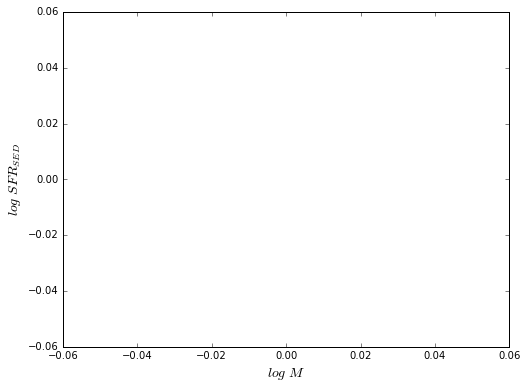

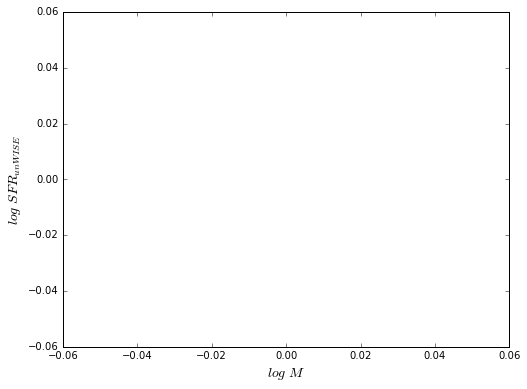

In [20]:
filamentFlag = (distV > 3.*u.Mpc) & (distV < 18.*u.Mpc) & dataflag & targetflag

plt.figure(figsize = (8,6))
plt.plot(logMass[filamentFlag & SEDflag], logSFR_SED[filamentFlag & SEDflag], '.')
plt.xlabel('$log \ M$', fontsize = 14)
plt.ylabel('$log \ SFR_{SED}$', fontsize = 14)


plt.figure(figsize = (8,6))
plt.plot(logMass[filamentFlag & UWflag], logSFR_UW[filamentFlag & UWflag], '.')
plt.xlabel('$log \ M$', fontsize = 14)
plt.ylabel('$log \ SFR_{unWISE}$', fontsize = 14)


# Try this again with our own WISE data

### NUV-r vs. M

/Users/kellywhalen/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/Users/kellywhalen/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


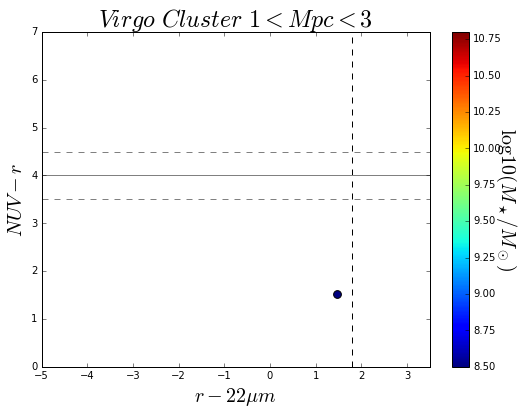

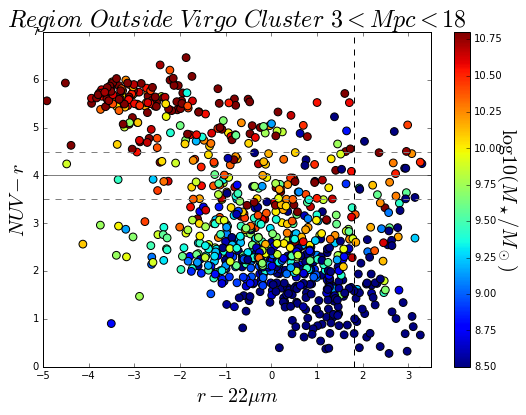

In [37]:
#NUV-r
nsa.nsamag = 22.5-2.5*np.log10(nsa.NMGY)
NUVr = nsa.ABSMAG[:,1] - nsa.ABSMAG[:,4]
wflag = (wise.W4MPRO > 0.1) & (wise.W4SNR > 2.)

cflag =  wflag  & clusterFlag

r22 = nsa.nsamag[:,4] - (wise.W4MPRO + 6.620) #convert to AB magnitude

#Define stellar mass
plt.figure(figsize = (8,6))
plt.scatter(r22[cflag], NUVr[cflag], c=logMass[cflag], s = 60, vmin = 8.5, vmax = 10.8)
cb = plt.colorbar(fraction = 0.08)
plt.axis([-5,3.5,0,7])
plt.xlabel('$r - 22\mu m$', fontsize=20)
plt.ylabel('$NUV-r$', fontsize=20)
plt.axvline(x=1.8,ls='--',color='k')
plt.axhline(y=4,ls='-',color='0.5')
plt.axhline(y=4.5,ls='--',color='0.5')
plt.axhline(y=3.5,ls='--',color='0.5')
cb.ax.text(2.5, .5,'$\log{10}(M_\star/M_\odot)$', rotation = -90, verticalalignment = 'center', fontsize = 20)
plt.title('$Virgo\ Cluster \ 1 < Mpc <3$', fontsize = 24)


cflag =  wflag  & filamentFlag
plt.figure(figsize = (8,6))
plt.scatter(r22[cflag], NUVr[cflag], c=logMass[cflag], s = 60, vmin = 8.5, vmax = 10.8)
cb = plt.colorbar(fraction = 0.08)
plt.axis([-5,3.5,0,7])
plt.xlabel('$r - 22\mu m$', fontsize=20)
plt.ylabel('$NUV-r$', fontsize=20)
plt.axvline(x=1.8,ls='--',color='k')
plt.axhline(y=4,ls='-',color='0.5')
plt.axhline(y=4.5,ls='--',color='0.5')
plt.axhline(y=3.5,ls='--',color='0.5')
cb.ax.text(2.5, .5,'$\log{10}(M_\star/M_\odot)$', rotation = -90, verticalalignment = 'center', fontsize = 20)
plt.title('$Region \ Outside \ Virgo\ Cluster \ 3 < Mpc <18$', fontsize = 24)



## SFR vs. M: Virgo Cluster

In [41]:
import chary_elbaz_24um as chary

ImportError: No module named idlsave